In [25]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [26]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [27]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle= True,
image_size = (IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [28]:
class_name = dataset.class_names

In [29]:
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [30]:
len(dataset)

68

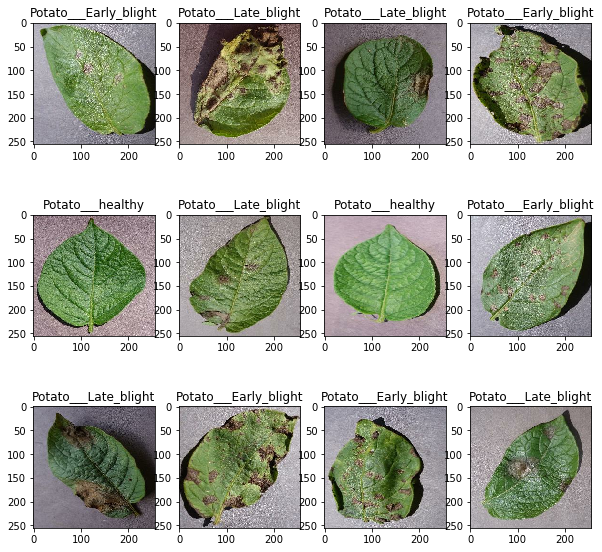

In [31]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
    #print(image_batch.shape)
    #print(label_batch.numpy())

In [32]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [33]:
train_ds = dataset.take(54)


In [34]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [35]:
val_size = 0.1

In [36]:
val_ds = test_ds.take(6)

In [37]:
test_ds = test_ds.skip(6)

In [38]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [39]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [41]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [42]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [43]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3 

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_4 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

In [45]:
model.compile(
	optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [46]:
history = model.fit(
	train_ds,
    epochs= EPOCHS,
    batch_size = BATCH_SIZE,
    verbose =1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 107s 2s/step - loss: 1.7161 - accuracy: 0.5671 - val_loss: 0.7098 - val_accuracy: 0.6979
Epoch 2/50
54/54 [==============================] - 100s 2s/step - loss: 0.4915 - accuracy: 0.7917 - val_loss: 0.2559 - val_accuracy: 0.9010
Epoch 3/50
54/54 [==============================] - 91s 2s/step - loss: 0.2927 - accuracy: 0.8860 - val_loss: 0.1845 - val_accuracy: 0.9167
Epoch 4/50
54/54 [==============================] - 91s 2s/step - loss: 0.1954 - accuracy: 0.9219 - val_loss: 1.1013 - val_accuracy: 0.5885
Epoch 5/50
54/54 [==============================] - 88s 2s/step - loss: 0.2454 - accuracy: 0.8976 - val_loss: 0.1354 - val_accuracy: 0.9427
Epoch 6/50
54/54 [==============================] - 84s 2s/step - loss: 0.1784 - accuracy: 0.9340 - val_loss: 0.1504 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 97s 2s/step - loss: 0.2203 - accuracy: 0.9155 - val_loss: 0.4774 - val_accuracy: 0.8281
Epoch 8/50
54/54 [

In [47]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 338ms/step - loss: 0.0446 - accuracy: 0.9844


In [48]:
scores

[0.044608909636735916, 0.984375]

In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
history.history['accuracy']

[0.5671296119689941,
 0.7916666865348816,
 0.8859953880310059,
 0.921875,
 0.8975694179534912,
 0.9340277910232544,
 0.9155092835426331,
 0.9317129850387573,
 0.9398148059844971,
 0.9589120149612427,
 0.9646990895271301,
 0.9375,
 0.9600694179534912,
 0.9710648059844971,
 0.9652777910232544,
 0.9641203880310059,
 0.9728009104728699,
 0.9704861044883728,
 0.9571759104728699,
 0.9699074029922485,
 0.9670138955116272,
 0.9716435074806213,
 0.9780092835426331,
 0.9618055820465088,
 0.9733796119689941,
 0.9594907164573669,
 0.9780092835426331,
 0.9716435074806213,
 0.9739583134651184,
 0.9861111044883728,
 0.9652777910232544,
 0.9623842835426331,
 0.9733796119689941,
 0.9693287014961243,
 0.9797453880310059,
 0.9890046119689941,
 0.9820601940155029,
 0.9722222089767456,
 0.9716435074806213,
 0.9849537014961243,
 0.9895833134651184,
 0.9768518805503845,
 0.9849537014961243,
 0.9890046119689941,
 0.9907407164573669,
 0.9803240895271301,
 0.9797453880310059,
 0.9878472089767456,
 0.98495370149

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

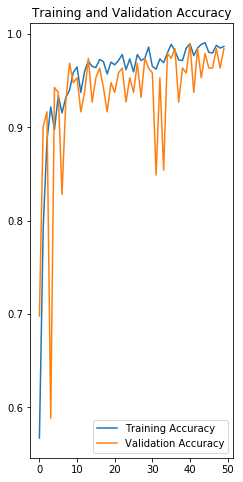

In [52]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label= 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

In [53]:
import numpy as np

First Image to predict
First Image's actual label:  Potato___Late_blight
Potato___Late_blight


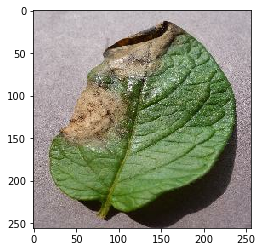

In [54]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("First Image to predict")
    plt.imshow(first_image)
    print("First Image's actual label: ", class_name[first_label])
    
    batch_prediction = model.predict(image_batch)
    print(class_name[np.argmax(batch_prediction[0])])

In [55]:
 def predict(model, img):
        img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
        img_array = tf.expand_dims(img_array, 0 )
        
        prediction = model.predict(img_array)
        
        predicted_class = class_name[np.argmax(prediction[0])]
        confidence = round(100 * (np.max(prediction[0])), 2)
        return predicted_class, confidence

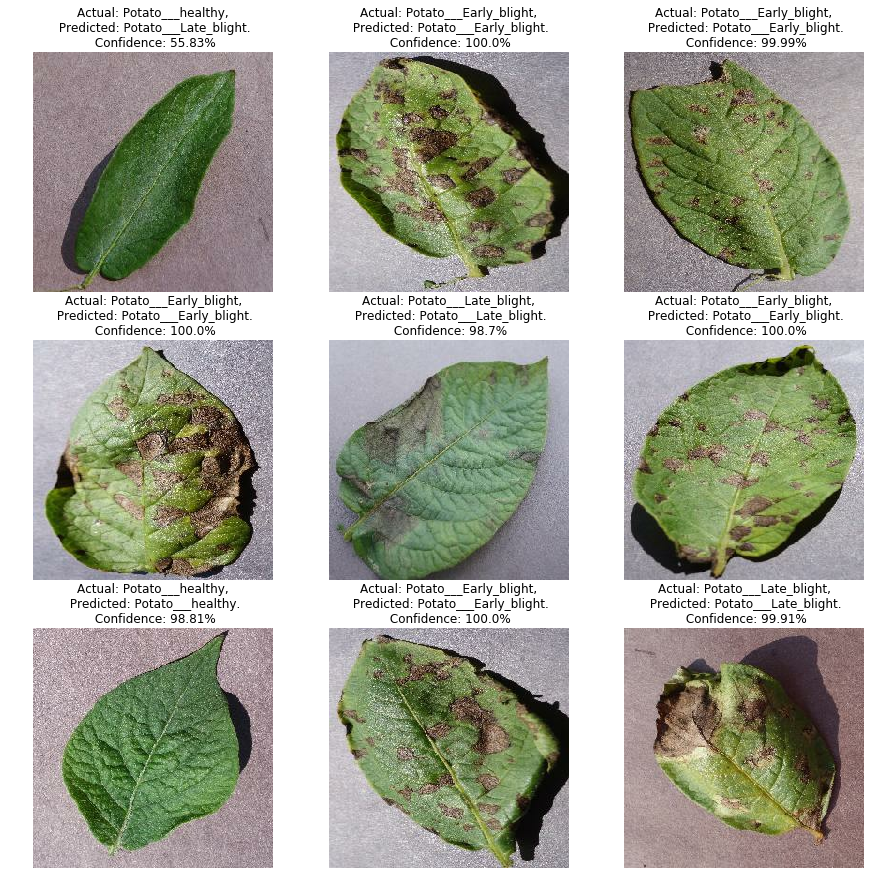

In [56]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [57]:
model_version = 1
model.save('model.h5')